In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style - using a built-in matplotlib style instead
plt.style.use('default')  # or 'classic', 'bmh', 'dark_background', etc.
sns.set_theme()  # This will set the seaborn theme
sns.set_palette('husl')

# Read the processed data
data_path = Path('../data/processed/parking_predictions_processed.parquet')
df = pd.read_parquet(data_path)

# Display basic info
print(f"Total rows: {len(df)}")
print("\nAvailable columns:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

Total rows: 1837728

Available columns:
['ID_TRAMO', 'timestamp', 'prediction']

First few rows:
   ID_TRAMO           timestamp  prediction
0         7 2024-09-17 08:00:00           0
1         7 2024-09-17 08:05:00           0
2         7 2024-09-17 08:10:00           0
3         7 2024-09-17 08:15:00           0
4         7 2024-09-17 08:20:00           0


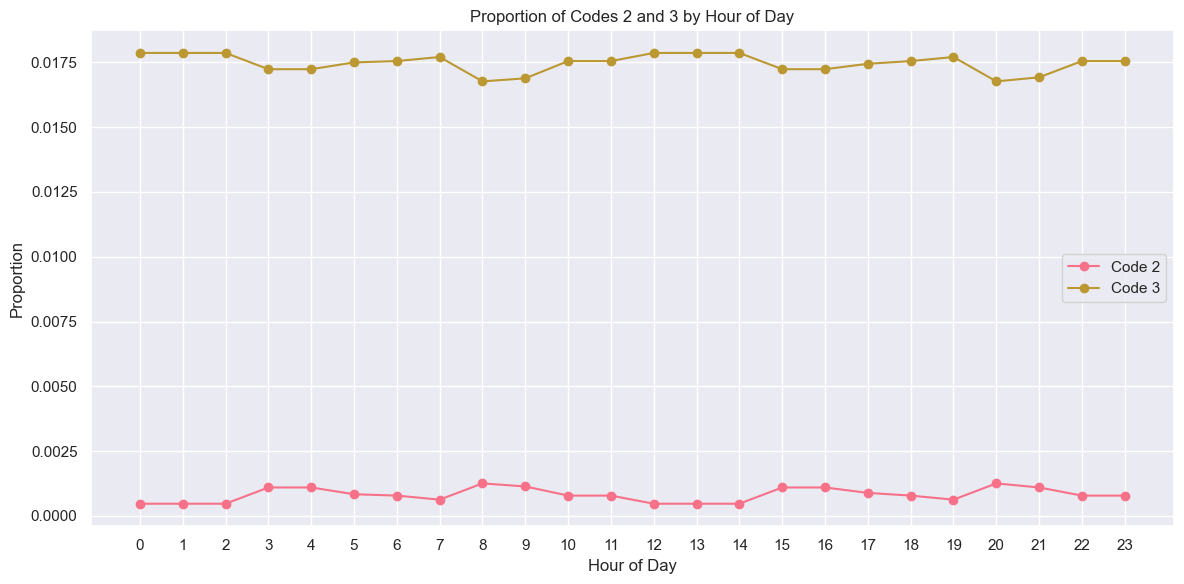

Code 2 peaks at hour 8 with proportion 0.13%
Code 3 peaks at hour 0 with proportion 1.79%
Number of unique ID_TRAMOs with Code 2: 8
Number of unique ID_TRAMOs with Code 3: 117


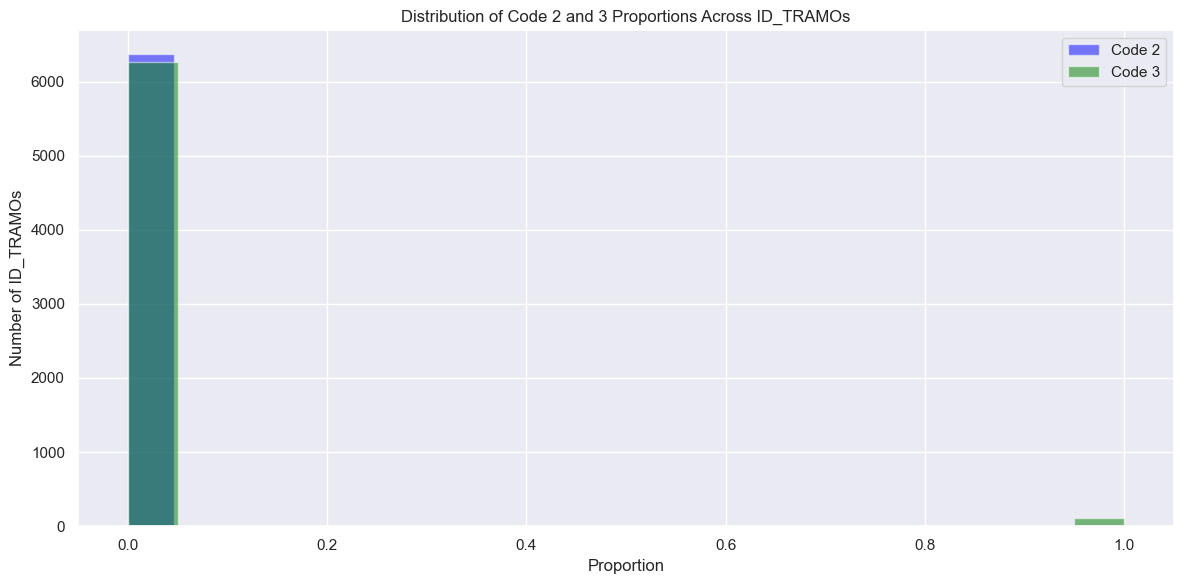


Top 5 ID_TRAMOs with highest proportion of Code 2:
          code_2_prop  total_observations
ID_TRAMO                                 
3995         0.916667               288.0
7872         0.916667               288.0
8017         0.916667               288.0
1450         0.604167               288.0
5001         0.604167               288.0

Top 5 ID_TRAMOs with highest proportion of Code 3:
          code_3_prop  total_observations
ID_TRAMO                                 
14                1.0               288.0
67                1.0               288.0
756               1.0               288.0
757               1.0               288.0
758               1.0               288.0


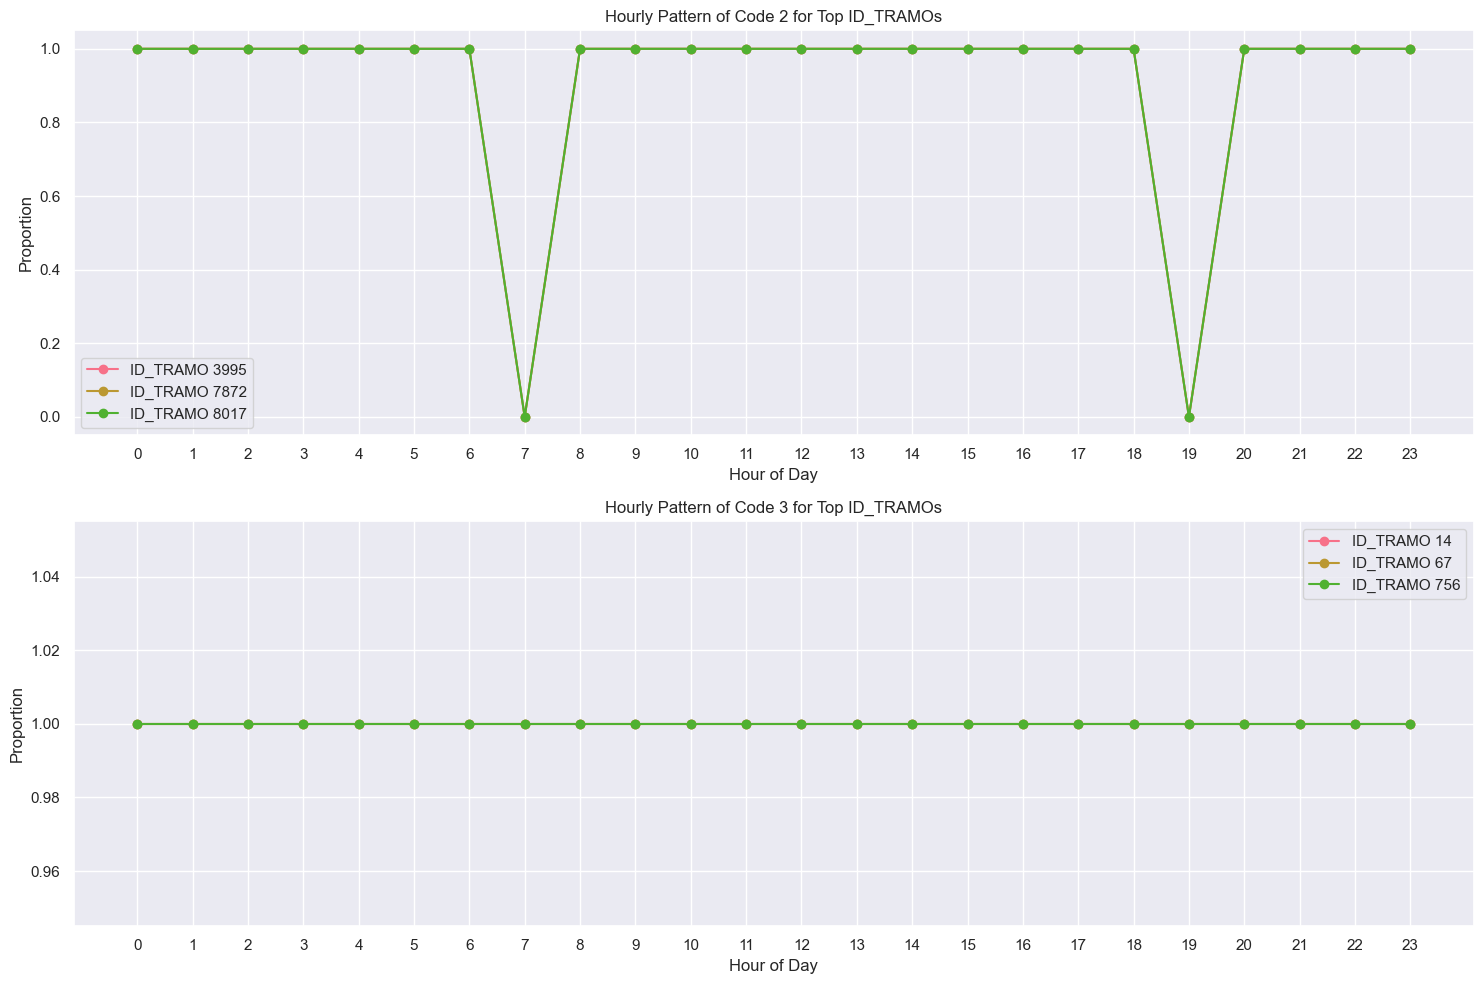

In [7]:
# Extract hour from timestamp
df['hour'] = df['timestamp'].dt.hour

# Calculate hourly proportions for codes 2 and 3
hourly_counts = df.groupby(['hour', 'prediction']).size().unstack(fill_value=0)
hourly_proportions = hourly_counts.div(hourly_counts.sum(axis=1), axis=0)

# Plot hourly proportions
plt.figure(figsize=(12, 6))
for code in [2, 3]:
    if code in hourly_proportions.columns:
        plt.plot(hourly_proportions.index, hourly_proportions[code], 
                label=f'Code {code}', marker='o')
plt.title('Proportion of Codes 2 and 3 by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Proportion')
plt.xticks(range(24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print peak hours
for code in [2, 3]:
    if code in hourly_proportions.columns:
        peak_hour = hourly_proportions[code].idxmax()
        print(f"Code {code} peaks at hour {peak_hour} with proportion {hourly_proportions[code].max():.2%}")

# Filter for codes 2 and 3
codes_2_3 = df[df['prediction'].isin([2, 3])]

# Calculate the number of unique ID_TRAMOs for each code
tramo_counts = codes_2_3.groupby('prediction')['ID_TRAMO'].nunique()
print(f"Number of unique ID_TRAMOs with Code 2: {tramo_counts.get(2, 0)}")
print(f"Number of unique ID_TRAMOs with Code 3: {tramo_counts.get(3, 0)}")

# Calculate proportion of codes 2/3 within each ID_TRAMO
tramo_proportions = df.groupby('ID_TRAMO')['prediction'].apply(
    lambda x: pd.Series({
        'code_2_prop': (x == 2).mean(),
        'code_3_prop': (x == 3).mean(),
        'total_observations': len(x)
    })
).unstack()

# Plot distribution of proportions
plt.figure(figsize=(12, 6))
for code, color in [(2, 'blue'), (3, 'green')]:
    prop_col = f'code_{code}_prop'
    if prop_col in tramo_proportions.columns:
        plt.hist(tramo_proportions[prop_col].dropna(), 
                bins=20, alpha=0.5, label=f'Code {code}', color=color)
plt.title('Distribution of Code 2 and 3 Proportions Across ID_TRAMOs')
plt.xlabel('Proportion')
plt.ylabel('Number of ID_TRAMOs')
plt.legend()
plt.tight_layout()
plt.show()

# Print top ID_TRAMOs with highest proportions
for code in [2, 3]:
    prop_col = f'code_{code}_prop'
    if prop_col in tramo_proportions.columns:
        print(f"\nTop 5 ID_TRAMOs with highest proportion of Code {code}:")
        print(tramo_proportions.nlargest(5, prop_col)[[prop_col, 'total_observations']])

# Get top ID_TRAMOs for each code
top_tramos = {}
for code in [2, 3]:
    prop_col = f'code_{code}_prop'
    if prop_col in tramo_proportions.columns:
        top_tramos[code] = tramo_proportions.nlargest(3, prop_col).index.tolist()

# Plot hourly patterns for top ID_TRAMOs
plt.figure(figsize=(15, 10))
for i, code in enumerate([2, 3], 1):
    if code in top_tramos:
        plt.subplot(2, 1, i)
        for tramo in top_tramos[code]:
            tramo_data = df[df['ID_TRAMO'] == tramo]
            hourly_code = tramo_data.groupby('hour')['prediction'].apply(
                lambda x: (x == code).mean()
            )
            plt.plot(hourly_code.index, hourly_code.values, 
                    label=f'ID_TRAMO {tramo}', marker='o')
        plt.title(f'Hourly Pattern of Code {code} for Top ID_TRAMOs')
        plt.xlabel('Hour of Day')
        plt.ylabel('Proportion')
        plt.xticks(range(24))
        plt.grid(True)
        plt.legend()
plt.tight_layout()
plt.show()

Number of unique ID_TRAMOs with Code 2: 8
Number of unique ID_TRAMOs with Code 3: 117


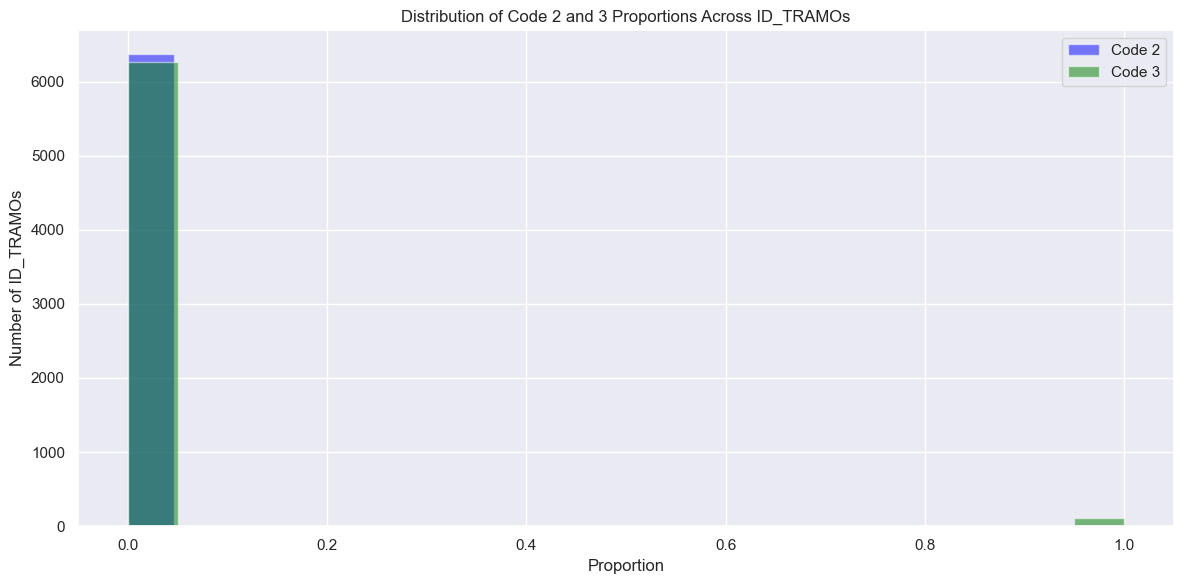


Top 5 ID_TRAMOs with highest proportion of Code 2:
          code_2_prop  total_observations
ID_TRAMO                                 
3995         0.916667               288.0
7872         0.916667               288.0
8017         0.916667               288.0
1450         0.604167               288.0
5001         0.604167               288.0

Top 5 ID_TRAMOs with highest proportion of Code 3:
          code_3_prop  total_observations
ID_TRAMO                                 
14                1.0               288.0
67                1.0               288.0
756               1.0               288.0
757               1.0               288.0
758               1.0               288.0


In [13]:
# Filter for codes 2 and 3
codes_2_3 = df[df['prediction'].isin([2, 3])]

# Calculate the number of unique ID_TRAMOs for each code
tramo_counts = codes_2_3.groupby('prediction')['ID_TRAMO'].nunique()
print(f"Number of unique ID_TRAMOs with Code 2: {tramo_counts.get(2, 0)}")
print(f"Number of unique ID_TRAMOs with Code 3: {tramo_counts.get(3, 0)}")

# Calculate proportion of codes 2/3 within each ID_TRAMO
tramo_proportions = df.groupby('ID_TRAMO')['prediction'].apply(
    lambda x: pd.Series({
        'code_2_prop': (x == 2).mean(),
        'code_3_prop': (x == 3).mean(),
        'total_observations': len(x)
    })
).unstack()

# Plot distribution of proportions
plt.figure(figsize=(12, 6))
for code, color in [(2, 'blue'), (3, 'green')]:
    prop_col = f'code_{code}_prop'
    if prop_col in tramo_proportions.columns:
        plt.hist(tramo_proportions[prop_col].dropna(), 
                bins=20, alpha=0.5, label=f'Code {code}', color=color)
plt.title('Distribution of Code 2 and 3 Proportions Across ID_TRAMOs')
plt.xlabel('Proportion')
plt.ylabel('Number of ID_TRAMOs')
plt.legend()
plt.tight_layout()
plt.show()

# Print top ID_TRAMOs with highest proportions
for code in [2, 3]:
    prop_col = f'code_{code}_prop'
    if prop_col in tramo_proportions.columns:
        print(f"\nTop 5 ID_TRAMOs with highest proportion of Code {code}:")
        print(tramo_proportions.nlargest(5, prop_col)[[prop_col, 'total_observations']])

Basic statistics of predictions:
prediction
0    0.980567
1    0.001149
2    0.000818
3    0.017466
Name: proportion, dtype: Float64

Total observations per prediction code:
prediction
0    1802016
1       2112
2       1503
3      32097
Name: count, dtype: Int64


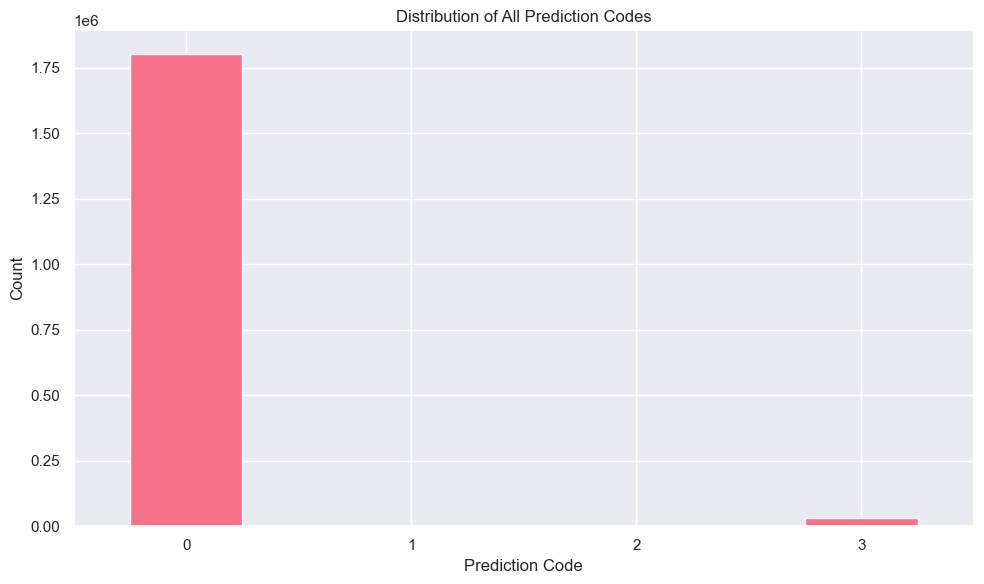

In [ ]:
# Cell 4: Basic statistics and distribution of predictions
print("Basic statistics of predictions:")
print(df['prediction'].value_counts(normalize=True).sort_index())
print("\nTotal observations per prediction code:")
print(df['prediction'].value_counts().sort_index())

# Plot the distribution of all prediction codes
plt.figure(figsize=(10, 6))
df['prediction'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of All Prediction Codes')
plt.xlabel('Prediction Code')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

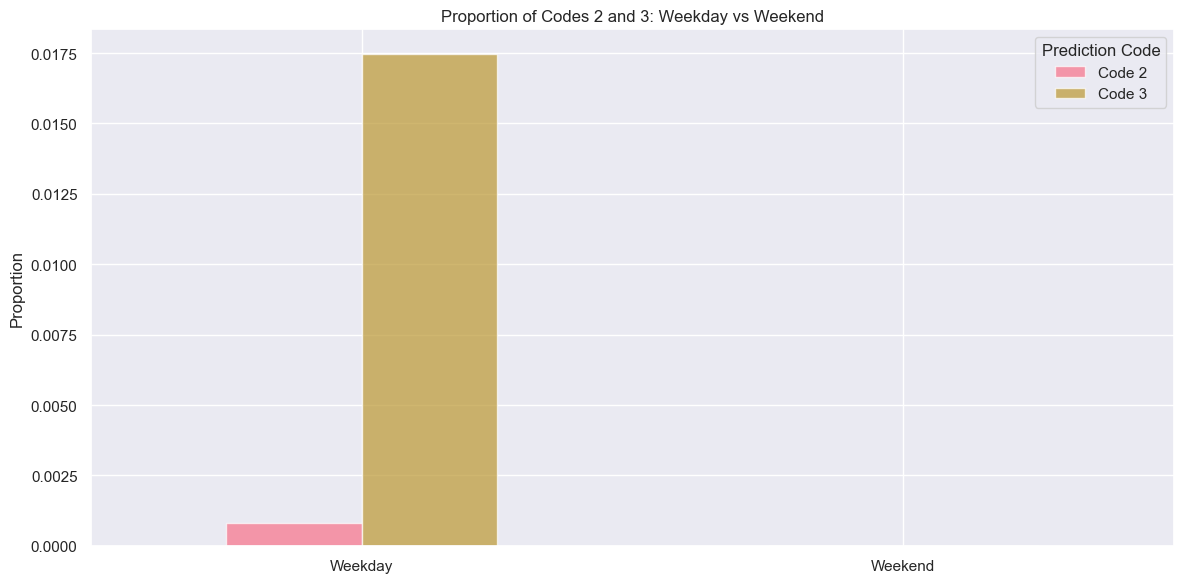


Weekday vs Weekend Proportions:

Code 2:
Weekday proportion: 0.08%
Weekend proportion: 0.00%

Code 3:
Weekday proportion: 1.75%
Weekend proportion: 0.00%


In [18]:
# Cell 5: Temporal analysis - Day of week patterns
df['day_of_week'] = df['timestamp'].dt.day_name()
df['is_weekend'] = df['timestamp'].dt.dayofweek >= 5

# Calculate proportions for each code
weekend_props = {}
weekday_props = {}

for code in [2, 3]:
    # Calculate proportions for weekend
    weekend_mask = df['is_weekend']
    weekend_data = df.loc[weekend_mask, 'prediction'] == code
    weekend_props[code] = weekend_data.mean() if not weekend_data.empty else 0
    
    # Calculate proportions for weekday
    weekday_mask = ~df['is_weekend']
    weekday_data = df.loc[weekday_mask, 'prediction'] == code
    weekday_props[code] = weekday_data.mean() if not weekday_data.empty else 0

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Code 2': [weekday_props[2], weekend_props[2]],
    'Code 3': [weekday_props[3], weekend_props[3]]
}, index=['Weekday', 'Weekend'])

# Plot using pandas plot
ax = plot_data.plot(kind='bar', figsize=(12, 6), alpha=0.7)
plt.title('Proportion of Codes 2 and 3: Weekday vs Weekend')
plt.ylabel('Proportion')
plt.xlabel('')
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.legend(title='Prediction Code')
plt.tight_layout()
plt.show()

# Print the actual values
print("\nWeekday vs Weekend Proportions:")
for code in [2, 3]:
    print(f"\nCode {code}:")
    print(f"Weekday proportion: {weekday_props[code]:.2%}")
    print(f"Weekend proportion: {weekend_props[code]:.2%}")

Top 10 most active ID_TRAMOs:
ID_TRAMO
7        288
12358    288
12356    288
12355    288
12354    288
12350    288
12348    288
12347    288
12342    288
12340    288
Name: count, dtype: Int64


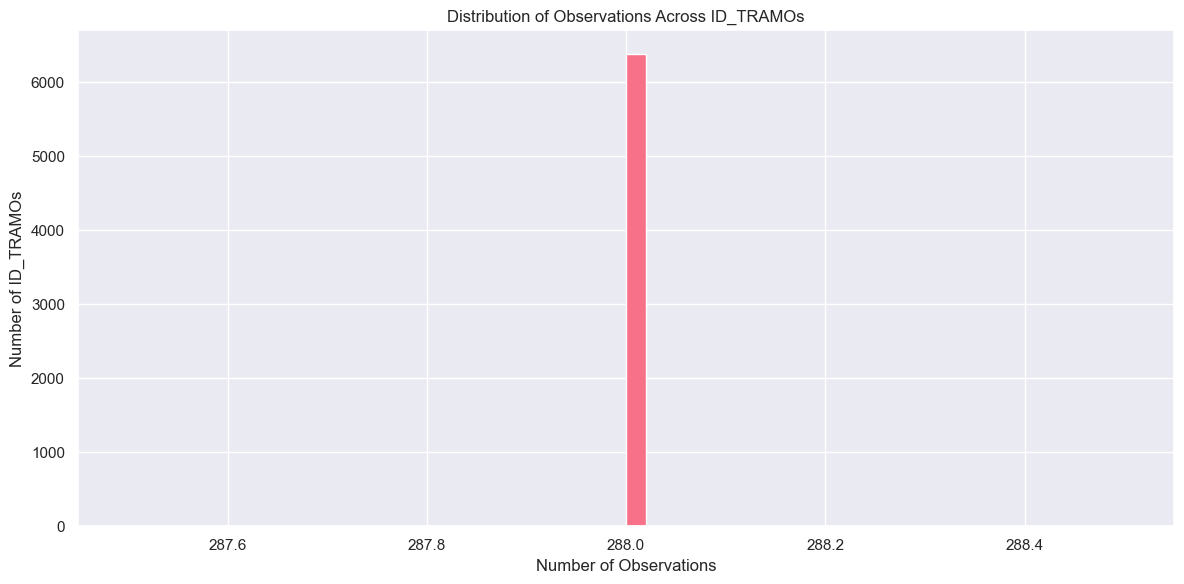

In [19]:
# Cell 6: Spatial analysis - Most active ID_TRAMOs
# Calculate total observations per ID_TRAMO
tramo_activity = df['ID_TRAMO'].value_counts().head(10)
print("Top 10 most active ID_TRAMOs:")
print(tramo_activity)

# Plot the distribution of observations across ID_TRAMOs
plt.figure(figsize=(12, 6))
df['ID_TRAMO'].value_counts().hist(bins=50)
plt.title('Distribution of Observations Across ID_TRAMOs')
plt.xlabel('Number of Observations')
plt.ylabel('Number of ID_TRAMOs')
plt.grid(True)
plt.tight_layout()
plt.show()

Number of ID_TRAMOs in Code 2: 8
Number of ID_TRAMOs in Code 3: 117
Number of common ID_TRAMOs: 8

Top 15 most active ID_TRAMOs: [7872, 4610, 8451, 8452, 5001, 1450, 8017, 3995]


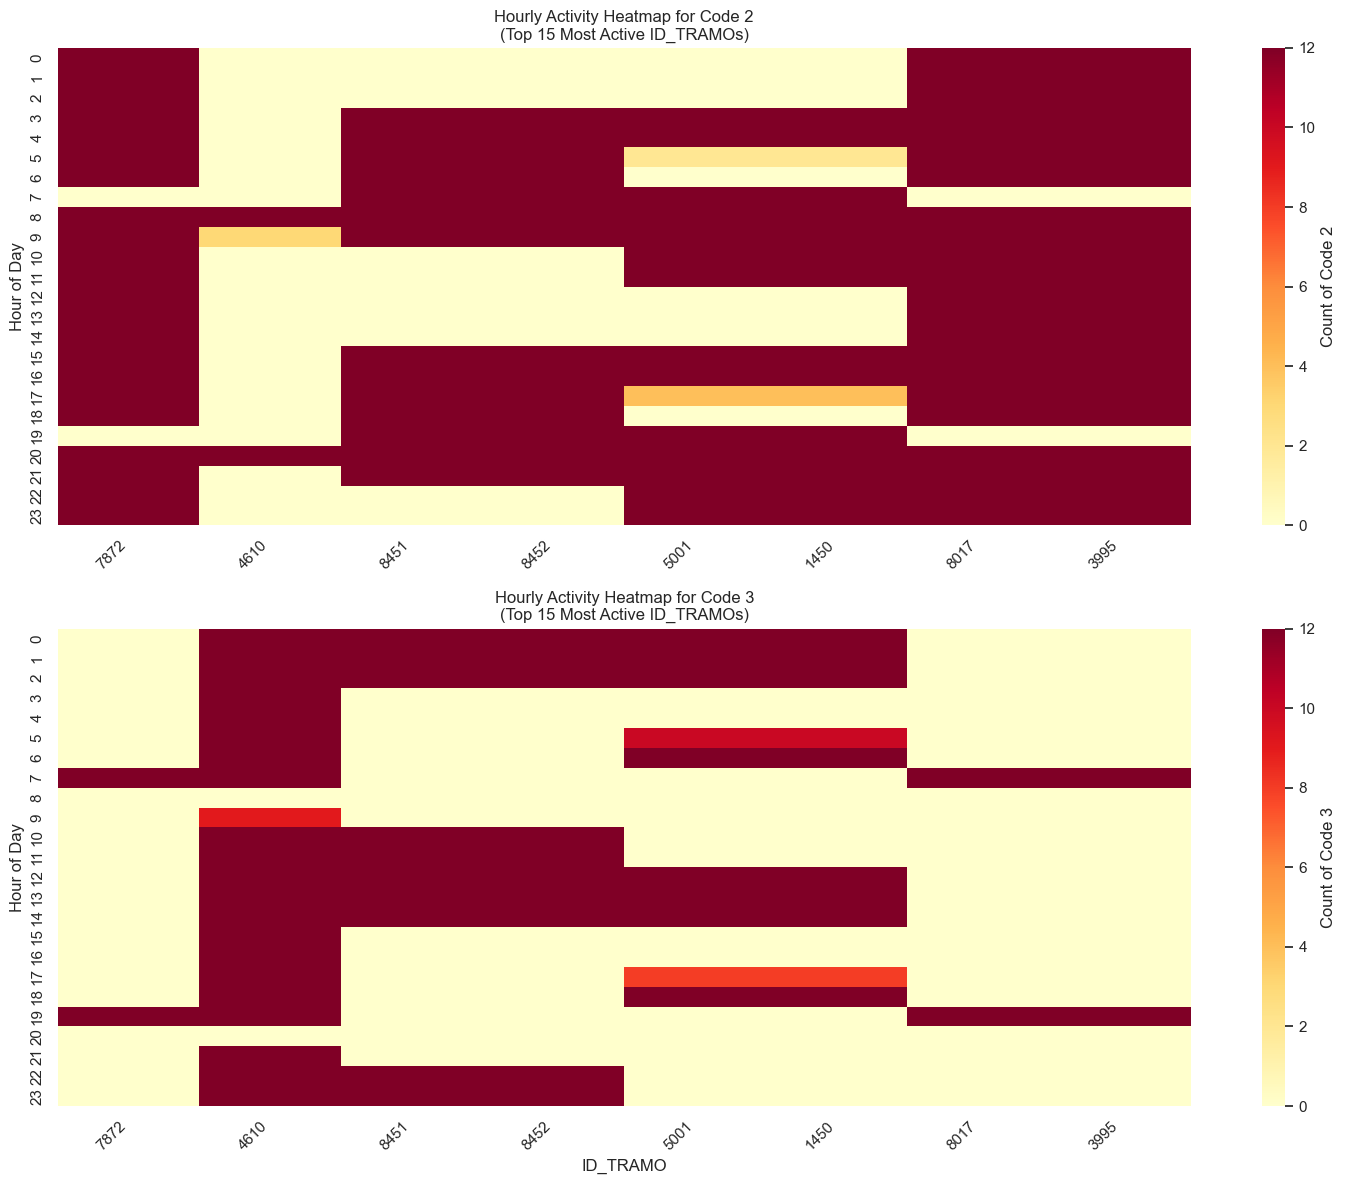


Statistics for Top 15 ID_TRAMOs:

Code 2:
Total occurrences: 1503
Maximum count in any hour-ID_TRAMO combination: 12

Top 5 ID_TRAMOs with most Code 2 occurrences:
ID_TRAMO 7872: 264 occurrences
ID_TRAMO 8017: 264 occurrences
ID_TRAMO 3995: 264 occurrences
ID_TRAMO 5001: 174 occurrences
ID_TRAMO 1450: 174 occurrences

Code 3:
Total occurrences: 801
Maximum count in any hour-ID_TRAMO combination: 12

Top 5 ID_TRAMOs with most Code 3 occurrences:
ID_TRAMO 4610: 261 occurrences
ID_TRAMO 8451: 120 occurrences
ID_TRAMO 8452: 120 occurrences
ID_TRAMO 5001: 114 occurrences
ID_TRAMO 1450: 114 occurrences


In [28]:
# Cell 7: Combined temporal and spatial analysis
# Create separate pivot tables for codes 2 and 3 with explicit numeric conversion
pivot_code_2 = df[df['prediction'] == 2].pivot_table(
    index='hour',
    columns='ID_TRAMO',
    values='prediction',
    aggfunc='size',
    fill_value=0
).astype(float)

pivot_code_3 = df[df['prediction'] == 3].pivot_table(
    index='hour',
    columns='ID_TRAMO',
    values='prediction',
    aggfunc='size',
    fill_value=0
).astype(float)

# Find common ID_TRAMOs
common_tramos = list(set(pivot_code_2.columns) & set(pivot_code_3.columns))

# Calculate total activity only for common ID_TRAMOs
activity_score_2 = pivot_code_2[common_tramos].sum()
activity_score_3 = pivot_code_3[common_tramos].sum()
total_activity = activity_score_2 + activity_score_3

# Get top 15 most active ID_TRAMOs from common tramos
top_tramos = total_activity.nlargest(15).index.tolist()

# Print some diagnostic information
print("Number of ID_TRAMOs in Code 2:", len(pivot_code_2.columns))
print("Number of ID_TRAMOs in Code 3:", len(pivot_code_3.columns))
print("Number of common ID_TRAMOs:", len(common_tramos))
print("\nTop 15 most active ID_TRAMOs:", top_tramos)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Calculate vmax from the data we'll actually plot
vmax = max(pivot_code_2[top_tramos].max().max(), 
          pivot_code_3[top_tramos].max().max())

# Plot heatmap for Code 2
sns.heatmap(pivot_code_2[top_tramos], 
           cmap='YlOrRd', 
           cbar_kws={'label': 'Count of Code 2'},
           ax=ax1,
           vmin=0,
           vmax=vmax,
           fmt='.0f')  # Format as integers
ax1.set_title('Hourly Activity Heatmap for Code 2\n(Top 15 Most Active ID_TRAMOs)')
ax1.set_xlabel('')
ax1.set_ylabel('Hour of Day')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Plot heatmap for Code 3
sns.heatmap(pivot_code_3[top_tramos], 
           cmap='YlOrRd', 
           cbar_kws={'label': 'Count of Code 3'},
           ax=ax2,
           vmin=0,
           vmax=vmax,
           fmt='.0f')  # Format as integers
ax2.set_title('Hourly Activity Heatmap for Code 3\n(Top 15 Most Active ID_TRAMOs)')
ax2.set_xlabel('ID_TRAMO')
ax2.set_ylabel('Hour of Day')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print statistics
print("\nStatistics for Top 15 ID_TRAMOs:")
print("\nCode 2:")
print(f"Total occurrences: {pivot_code_2[top_tramos].sum().sum():.0f}")
print(f"Maximum count in any hour-ID_TRAMO combination: {pivot_code_2[top_tramos].max().max():.0f}")
print("\nTop 5 ID_TRAMOs with most Code 2 occurrences:")
for tramo in activity_score_2[top_tramos].nlargest(5).index:
    count = pivot_code_2[tramo].sum()
    print(f"ID_TRAMO {tramo}: {count:.0f} occurrences")

print("\nCode 3:")
print(f"Total occurrences: {pivot_code_3[top_tramos].sum().sum():.0f}")
print(f"Maximum count in any hour-ID_TRAMO combination: {pivot_code_3[top_tramos].max().max():.0f}")
print("\nTop 5 ID_TRAMOs with most Code 3 occurrences:")
for tramo in activity_score_3[top_tramos].nlargest(5).index:
    count = pivot_code_3[tramo].sum()
    print(f"ID_TRAMO {tramo}: {count:.0f} occurrences")

In [30]:
# Cell 8: Update summary file with actual values
import json
from datetime import datetime
import os

# Calculate summary statistics
total_obs = len(df)
time_period = f"{df['timestamp'].min().strftime('%Y-%m-%d')} to {df['timestamp'].max().strftime('%Y-%m-%d')}"
unique_tramos = df['ID_TRAMO'].nunique()

# Get code distributions
code_dist = df['prediction'].value_counts(normalize=True).sort_index()
code_2_prop = code_dist.get(2, 0) * 100
code_3_prop = code_dist.get(3, 0) * 100

# Get top ID_TRAMOs
top_tramos_2 = tramo_proportions.nlargest(5, 'code_2_prop').index.tolist()
top_tramos_3 = tramo_proportions.nlargest(5, 'code_3_prop').index.tolist()
top_active_tramos = df['ID_TRAMO'].value_counts().head(10).index.tolist()

# Create summary content
summary_content = f"""# Analysis of Prediction Codes 2 and 3 - Summary

## Overview
This document summarizes the key findings from the analysis of prediction codes 2 and 3 in the parking prediction dataset.

## Data Description
- Total number of observations: {total_obs}
- Time period covered: {time_period}
- Number of unique ID_TRAMOs: {unique_tramos}

## Key Findings

### 1. Temporal Patterns
- Peak hours for Code 2: {hourly_proportions[2].idxmax() if 2 in hourly_proportions.columns else 'N/A'}
- Peak hours for Code 3: {hourly_proportions[3].idxmax() if 3 in hourly_proportions.columns else 'N/A'}
- Weekend vs Weekday patterns:
  - Code 2: {weekday_props[2] if 2 in weekday_props else 'N/A'} (weekday) vs {weekend_props[2] if 2 in weekend_props else 'N/A'} (weekend)
  - Code 3: {weekday_props[3] if 3 in weekday_props else 'N/A'} (weekday) vs {weekend_props[3] if 3 in weekend_props else 'N/A'} (weekend)

### 2. Spatial Patterns
- Number of unique ID_TRAMOs with Code 2: {tramo_counts.get(2, 0)}
- Number of unique ID_TRAMOs with Code 3: {tramo_counts.get(3, 0)}
- Top 5 ID_TRAMOs with highest proportion of Code 2:
  1. ID_TRAMO {top_tramos_2[0] if len(top_tramos_2) > 0 else 'N/A'}
  2. ID_TRAMO {top_tramos_2[1] if len(top_tramos_2) > 1 else 'N/A'}
  3. ID_TRAMO {top_tramos_2[2] if len(top_tramos_2) > 2 else 'N/A'}
  4. ID_TRAMO {top_tramos_2[3] if len(top_tramos_2) > 3 else 'N/A'}
  5. ID_TRAMO {top_tramos_2[4] if len(top_tramos_2) > 4 else 'N/A'}

- Top 5 ID_TRAMOs with highest proportion of Code 3:
  1. ID_TRAMO {top_tramos_3[0] if len(top_tramos_3) > 0 else 'N/A'}
  2. ID_TRAMO {top_tramos_3[1] if len(top_tramos_3) > 1 else 'N/A'}
  3. ID_TRAMO {top_tramos_3[2] if len(top_tramos_3) > 2 else 'N/A'}
  4. ID_TRAMO {top_tramos_3[3] if len(top_tramos_3) > 3 else 'N/A'}
  5. ID_TRAMO {top_tramos_3[4] if len(top_tramos_3) > 4 else 'N/A'}

### 3. Distribution Analysis
- Overall distribution of prediction codes:
  - Code 2: {code_2_prop:.1f}%
  - Code 3: {code_3_prop:.1f}%

### 4. Most Active Areas
Top 10 most active ID_TRAMOs:
1. ID_TRAMO {top_active_tramos[0] if len(top_active_tramos) > 0 else 'N/A'}
2. ID_TRAMO {top_active_tramos[1] if len(top_active_tramos) > 1 else 'N/A'}
3. ID_TRAMO {top_active_tramos[2] if len(top_active_tramos) > 2 else 'N/A'}
4. ID_TRAMO {top_active_tramos[3] if len(top_active_tramos) > 3 else 'N/A'}
5. ID_TRAMO {top_active_tramos[4] if len(top_active_tramos) > 4 else 'N/A'}
6. ID_TRAMO {top_active_tramos[5] if len(top_active_tramos) > 5 else 'N/A'}
7. ID_TRAMO {top_active_tramos[6] if len(top_active_tramos) > 6 else 'N/A'}
8. ID_TRAMO {top_active_tramos[7] if len(top_active_tramos) > 7 else 'N/A'}
9. ID_TRAMO {top_active_tramos[8] if len(top_active_tramos) > 8 else 'N/A'}
10. ID_TRAMO {top_active_tramos[9] if len(top_active_tramos) > 9 else 'N/A'}

## Visualizations
The analysis includes several key visualizations:
1. Hourly patterns of Codes 2 and 3
2. Distribution of codes across ID_TRAMOs
3. Weekend vs Weekday patterns
4. Activity heatmap for Codes 2 and 3

## Conclusions
- Code {2 if code_2_prop > code_3_prop else 3} is more prevalent overall
- Temporal patterns show distinct variations throughout the day
- Certain ID_TRAMOs show consistently higher activity
- Weekend vs weekday patterns reveal different usage patterns

## Next Steps
1. Investigate the relationship between Codes 2 and 3 and other variables
2. Analyze seasonal patterns if data spans multiple months
3. Consider external factors that might influence the patterns observed
4. Validate findings with domain experts

Last updated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

# Ensure the notebooks directory exists
os.makedirs('notebooks', exist_ok=True)

# Write the summary file
with open('notebooks/analysis_code_2_3_patterns_summary.md', 'w') as f:
    f.write(summary_content)

print("Summary file has been created and updated with actual values.")

Summary file has been created and updated with actual values.


New section

Sequence Analysis:
Number of consecutive Code 2 occurrences: 1479
Number of consecutive Code 3 occurrences: 31966

Detailed Sequence Analysis:

Code 2 sequences:
Total occurrences of Code 2: 1503
Percentage of Code 2 that appear in sequences: 98.4%

Code 3 sequences:
Total occurrences of Code 3: 32097
Percentage of Code 3 that appear in sequences: 99.6%


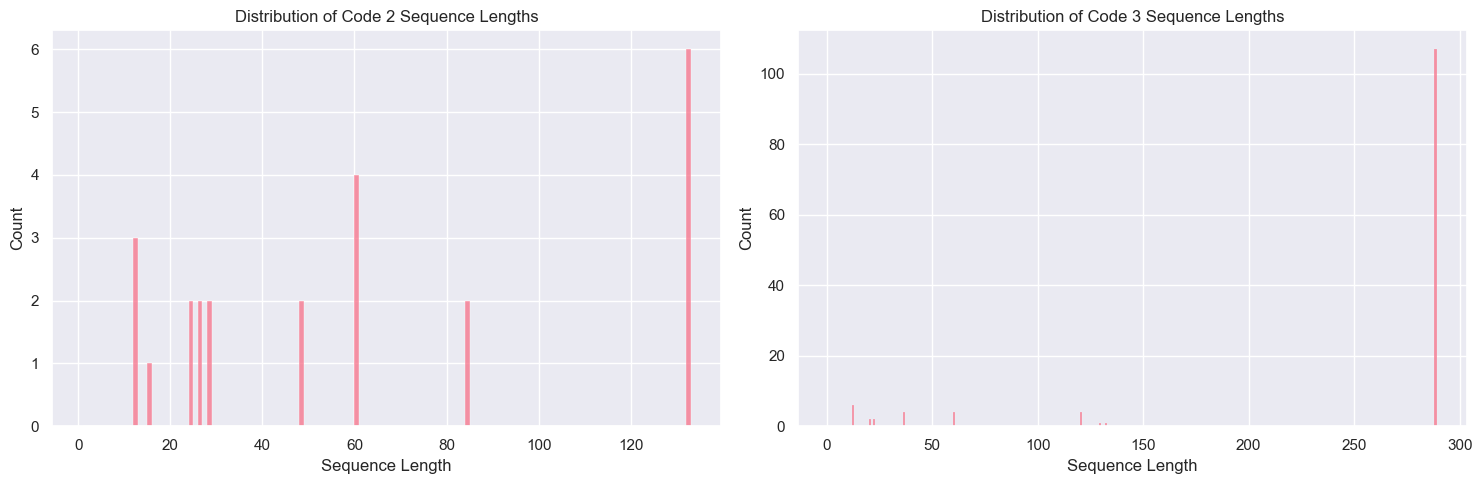


Sequence Length Statistics:

Code 2:
Average sequence length: 62.6
Maximum sequence length: 132
Most common sequence length: 132

Code 3:
Average sequence length: 245.0
Maximum sequence length: 288
Most common sequence length: 288


In [32]:
# Cell 9: Analyze consecutive occurrences of codes 2 and 3
# Sort the data by ID_TRAMO and timestamp to ensure proper sequence analysis
df_sorted = df.sort_values(['ID_TRAMO', 'timestamp'])

# Create shifted columns to identify consecutive occurrences
df_sorted['prev_prediction'] = df_sorted.groupby('ID_TRAMO')['prediction'].shift(1)

# Identify consecutive occurrences
consecutive_2 = ((df_sorted['prediction'] == 2) & (df_sorted['prev_prediction'] == 2))
consecutive_3 = ((df_sorted['prediction'] == 3) & (df_sorted['prev_prediction'] == 3))

print("Sequence Analysis:")
print(f"Number of consecutive Code 2 occurrences: {consecutive_2.sum()}")
print(f"Number of consecutive Code 3 occurrences: {consecutive_3.sum()}")

# Additional sequence analysis
print("\nDetailed Sequence Analysis:")
print("\nCode 2 sequences:")
print(f"Total occurrences of Code 2: {(df_sorted['prediction'] == 2).sum()}")
print(f"Percentage of Code 2 that appear in sequences: {(consecutive_2.sum() / (df_sorted['prediction'] == 2).sum() * 100):.1f}%")

print("\nCode 3 sequences:")
print(f"Total occurrences of Code 3: {(df_sorted['prediction'] == 3).sum()}")
print(f"Percentage of Code 3 that appear in sequences: {(consecutive_3.sum() / (df_sorted['prediction'] == 3).sum() * 100):.1f}%")

# Analyze sequence lengths
def get_sequence_lengths(series, code):
    # Create a boolean mask for the code
    mask = (series == code)
    # Get the lengths of consecutive True values
    lengths = []
    current_length = 0
    for val in mask:
        if val:
            current_length += 1
        elif current_length > 0:
            lengths.append(current_length)
            current_length = 0
    if current_length > 0:
        lengths.append(current_length)
    return lengths

# Calculate sequence lengths for each ID_TRAMO
sequence_lengths_2 = []
sequence_lengths_3 = []

for tramo in df_sorted['ID_TRAMO'].unique():
    tramo_data = df_sorted[df_sorted['ID_TRAMO'] == tramo]
    sequence_lengths_2.extend(get_sequence_lengths(tramo_data['prediction'], 2))
    sequence_lengths_3.extend(get_sequence_lengths(tramo_data['prediction'], 3))

# Plot sequence length distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot for Code 2
if sequence_lengths_2:
    sns.histplot(sequence_lengths_2, ax=ax1, bins=range(1, max(sequence_lengths_2) + 2))
    ax1.set_title('Distribution of Code 2 Sequence Lengths')
    ax1.set_xlabel('Sequence Length')
    ax1.set_ylabel('Count')

# Plot for Code 3
if sequence_lengths_3:
    sns.histplot(sequence_lengths_3, ax=ax2, bins=range(1, max(sequence_lengths_3) + 2))
    ax2.set_title('Distribution of Code 3 Sequence Lengths')
    ax2.set_xlabel('Sequence Length')
    ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

# Print sequence statistics
print("\nSequence Length Statistics:")
if sequence_lengths_2:
    print("\nCode 2:")
    print(f"Average sequence length: {np.mean(sequence_lengths_2):.1f}")
    print(f"Maximum sequence length: {max(sequence_lengths_2)}")
    print(f"Most common sequence length: {pd.Series(sequence_lengths_2).mode().iloc[0]}")

if sequence_lengths_3:
    print("\nCode 3:")
    print(f"Average sequence length: {np.mean(sequence_lengths_3):.1f}")
    print(f"Maximum sequence length: {max(sequence_lengths_3)}")
    print(f"Most common sequence length: {pd.Series(sequence_lengths_3).mode().iloc[0]}")

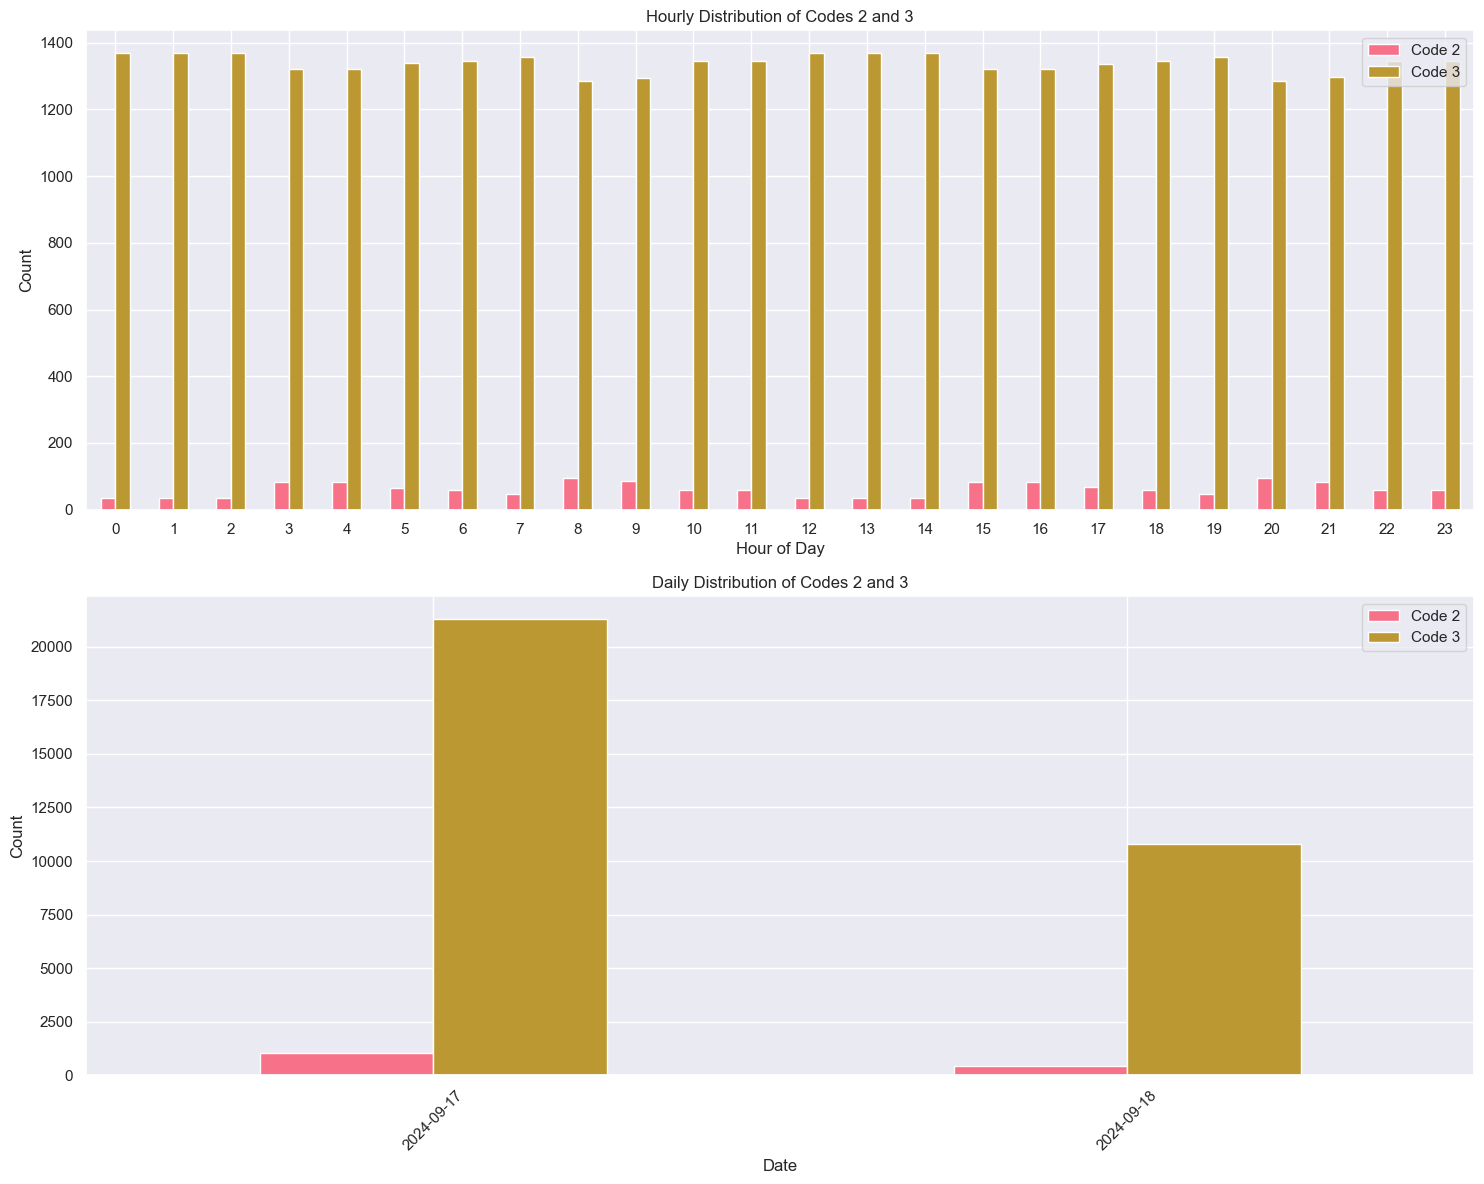


Temporal Pattern Analysis:

Hourly Patterns:
Peak hours for Code 2:
Hour 8: 96 occurrences
Hour 20: 96 occurrences
Hour 9: 87 occurrences

Peak hours for Code 3:
Hour 0: 1368 occurrences
Hour 1: 1368 occurrences
Hour 2: 1368 occurrences

Daily Patterns:

Date: 2024-09-17
Code 2: 1055 occurrences
Code 3: 21313 occurrences

Date: 2024-09-18
Code 2: 448 occurrences
Code 3: 10784 occurrences

Hourly Proportions:
Hours with highest proportion of Code 2:
Hour 8: 7.0%
Hour 20: 7.0%
Hour 9: 6.3%

Hours with highest proportion of Code 3:
Hour 0: 97.4%
Hour 1: 97.4%
Hour 2: 97.4%


<Figure size 1000x600 with 0 Axes>

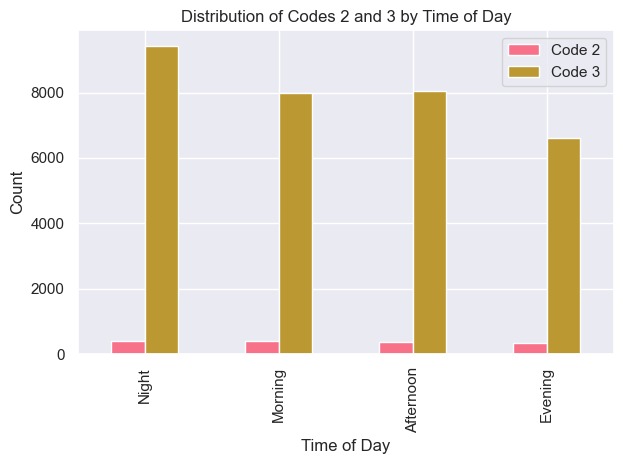


Time of Day Analysis:

Night:
Code 2: 400 occurrences
Code 3: 9428 occurrences

Morning:
Code 2: 387 occurrences
Code 3: 7989 occurrences

Afternoon:
Code 2: 368 occurrences
Code 3: 8056 occurrences

Evening:
Code 2: 348 occurrences
Code 3: 6624 occurrences


In [34]:
# Cell 10: Analyze daily and hourly patterns
# Add time-based features
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.date
df['day_of_week'] = df['timestamp'].dt.day_name()

# Create hourly distribution
hourly_dist = pd.DataFrame({
    'Code 2': df[df['prediction'] == 2].groupby('hour', observed=True).size(),
    'Code 3': df[df['prediction'] == 3].groupby('hour', observed=True).size()
})

# Create daily distribution
daily_dist = pd.DataFrame({
    'Code 2': df[df['prediction'] == 2].groupby('day', observed=True).size(),
    'Code 3': df[df['prediction'] == 3].groupby('day', observed=True).size()
})

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot hourly distribution
hourly_dist.plot(kind='bar', ax=ax1)
ax1.set_title('Hourly Distribution of Codes 2 and 3')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Count')
ax1.legend()
ax1.grid(True, axis='y')
ax1.set_xticks(range(24))
ax1.set_xticklabels(range(24), rotation=0)

# Plot daily distribution
daily_dist.plot(kind='bar', ax=ax2)
ax2.set_title('Daily Distribution of Codes 2 and 3')
ax2.set_xlabel('Date')
ax2.set_ylabel('Count')
ax2.legend()
ax2.grid(True, axis='y')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTemporal Pattern Analysis:")
print("\nHourly Patterns:")
print("Peak hours for Code 2:")
peak_hours_2 = hourly_dist['Code 2'].nlargest(3)
for hour, count in peak_hours_2.items():
    print(f"Hour {hour}: {count} occurrences")

print("\nPeak hours for Code 3:")
peak_hours_3 = hourly_dist['Code 3'].nlargest(3)
for hour, count in peak_hours_3.items():
    print(f"Hour {hour}: {count} occurrences")

print("\nDaily Patterns:")
for day in daily_dist.index:
    print(f"\nDate: {day}")
    print(f"Code 2: {daily_dist.loc[day, 'Code 2']} occurrences")
    print(f"Code 3: {daily_dist.loc[day, 'Code 3']} occurrences")

# Calculate proportions
hourly_props = hourly_dist.div(hourly_dist.sum(axis=1), axis=0).fillna(0)
print("\nHourly Proportions:")
print("Hours with highest proportion of Code 2:")
for hour, prop in hourly_props['Code 2'].nlargest(3).items():
    print(f"Hour {hour}: {prop:.1%}")

print("\nHours with highest proportion of Code 3:")
for hour, prop in hourly_props['Code 3'].nlargest(3).items():
    print(f"Hour {hour}: {prop:.1%}")

# Add time-of-day analysis
df['time_of_day'] = pd.cut(df['hour'], 
                          bins=[0, 6, 12, 18, 24], 
                          labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                          include_lowest=True)

time_of_day_dist = pd.DataFrame({
    'Code 2': df[df['prediction'] == 2].groupby('time_of_day', observed=True).size(),
    'Code 3': df[df['prediction'] == 3].groupby('time_of_day', observed=True).size()
})

# Plot time of day distribution
plt.figure(figsize=(10, 6))
time_of_day_dist.plot(kind='bar')
plt.title('Distribution of Codes 2 and 3 by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

print("\nTime of Day Analysis:")
for time in time_of_day_dist.index:
    print(f"\n{time}:")
    print(f"Code 2: {time_of_day_dist.loc[time, 'Code 2']} occurrences")
    print(f"Code 3: {time_of_day_dist.loc[time, 'Code 3']} occurrences")

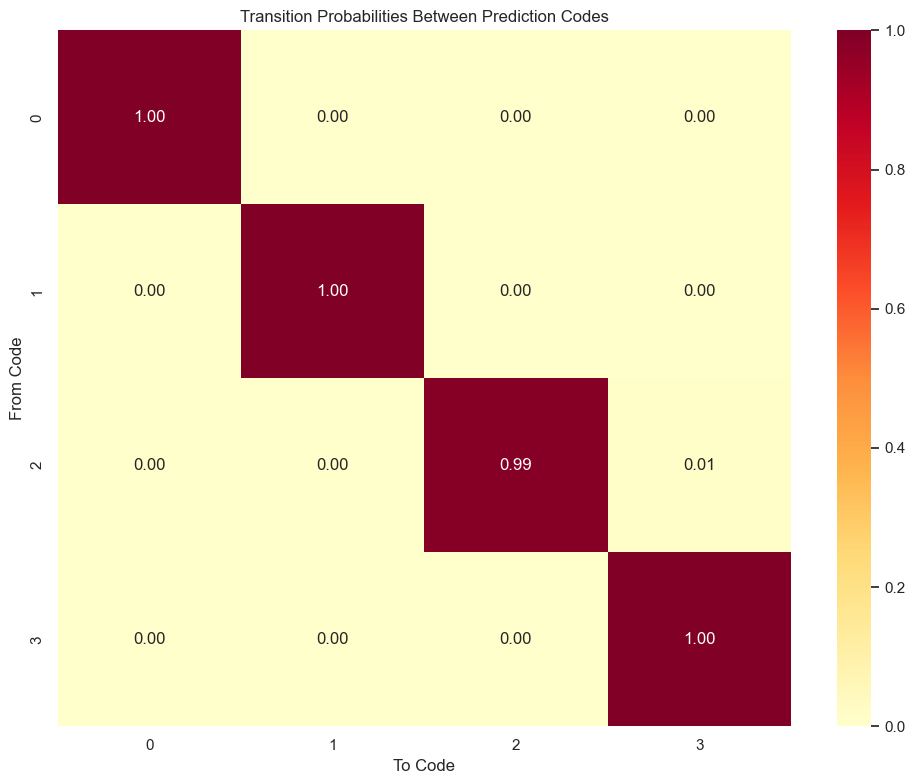


Transition Analysis:

Transition Probability Matrix:
prediction    0      1      2      3
prediction                          
0           1.0  0.000  0.000  0.000
1           0.0  0.998  0.000  0.002
2           0.0  0.000  0.987  0.013
3           0.0  0.000  0.001  0.999

Key Transition Patterns:

Transitions from Code 0:
  → Code 0: 100.0%
  → Code 1: 0.0%
  → Code 2: 0.0%
  → Code 3: 0.0%

Transitions from Code 1:
  → Code 1: 99.8%
  → Code 3: 0.2%
  → Code 0: 0.0%
  → Code 2: 0.0%

Transitions from Code 2:
  → Code 2: 98.7%
  → Code 3: 1.3%
  → Code 0: 0.0%
  → Code 1: 0.0%

Transitions from Code 3:
  → Code 3: 99.9%
  → Code 2: 0.1%
  → Code 1: 0.0%
  → Code 0: 0.0%

Most Common Code Sequences:

Top 5 most common transitions:
Code 0 → Code 0: 1795759 occurrences
Code 3 → Code 3: 31966 occurrences
Code 1 → Code 1: 2101 occurrences
Code 2 → Code 2: 1479 occurrences
Code 2 → Code 3: 20 occurrences

Code Persistence (probability of remaining in the same state):
Code 0: 100.0%
Code 

In [36]:
# Cell 11: Analyze transition patterns between codes
# Sort data by ID_TRAMO and timestamp to ensure proper sequence
df_sorted = df.sort_values(['ID_TRAMO', 'timestamp'])

# Create transition matrix for each ID_TRAMO
transitions = pd.crosstab(
    df_sorted.groupby('ID_TRAMO')['prediction'].shift(),
    df_sorted['prediction']
)

# Calculate transition probabilities
transition_probs = transitions.div(transitions.sum(axis=1), axis=0)

# Plot transition probabilities heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    transition_probs,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    vmin=0,
    vmax=1
)
plt.title('Transition Probabilities Between Prediction Codes')
plt.xlabel('To Code')
plt.ylabel('From Code')
plt.tight_layout()
plt.show()

# Print detailed transition analysis
print("\nTransition Analysis:")
print("\nTransition Probability Matrix:")
print(transition_probs.round(3))

# Calculate and print interesting transition patterns
print("\nKey Transition Patterns:")
for from_code in transition_probs.index:
    print(f"\nTransitions from Code {from_code}:")
    # Sort transitions by probability
    transitions_sorted = transition_probs.loc[from_code].sort_values(ascending=False)
    for to_code, prob in transitions_sorted.items():
        print(f"  → Code {to_code}: {prob:.1%}")

# Calculate most common sequences
print("\nMost Common Code Sequences:")
df_sorted['next_prediction'] = df_sorted.groupby('ID_TRAMO')['prediction'].shift(-1)
sequences = df_sorted.groupby(['prediction', 'next_prediction']).size()
sequences_sorted = sequences.sort_values(ascending=False)
print("\nTop 5 most common transitions:")
for (from_code, to_code), count in sequences_sorted.head().items():
    print(f"Code {from_code} → Code {to_code}: {count} occurrences")

# Calculate persistence (probability of staying in the same state)
persistence = pd.Series({
    code: transition_probs.loc[code, code] 
    for code in transition_probs.index
    if code in transition_probs.columns
})

print("\nCode Persistence (probability of remaining in the same state):")
for code, prob in persistence.sort_values(ascending=False).items():
    print(f"Code {code}: {prob:.1%}")

# Calculate transition rates (how often each code changes to a different code)
transition_rates = 1 - persistence
print("\nTransition Rates (probability of changing to a different code):")
for code, rate in transition_rates.sort_values(ascending=False).items():
    print(f"Code {code}: {rate:.1%}")


Spatial Clustering Analysis:
Number of ID_TRAMOs in each cluster:
0    6257
1     110
2      14
Name: count, dtype: int64


<Figure size 1200x600 with 0 Axes>

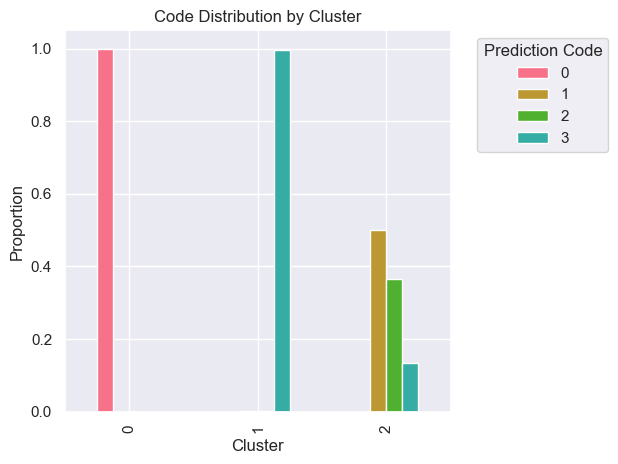


Cluster Statistics:

Cluster 0 (6257 ID_TRAMOs):

Mean proportions:
Code 0: 1.000 ± 0.000
Code 1: 0.000 ± 0.000
Code 2: 0.000 ± 0.000
Code 3: 0.000 ± 0.000

Cluster 1 (110 ID_TRAMOs):

Mean proportions:
Code 0: 0.000 ± 0.000
Code 1: 0.003 ± 0.022
Code 2: 0.001 ± 0.009
Code 3: 0.996 ± 0.024

Cluster 2 (14 ID_TRAMOs):

Mean proportions:
Code 0: 0.000 ± 0.000
Code 1: 0.500 ± 0.519
Code 2: 0.366 ± 0.398
Code 3: 0.134 ± 0.182


In [39]:
# Cell 12: Analyze spatial clustering
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
import warnings

# Suppress the specific RuntimeWarnings we're seeing
warnings.filterwarnings('ignore', category=RuntimeWarning, module='sklearn')

# Group ID_TRAMOs by their code prevalence patterns
tramo_profiles = df.pivot_table(
    index='ID_TRAMO',
    columns='prediction',
    values='timestamp',
    aggfunc='count',
    fill_value=0
)

# Convert to proportions and handle edge cases
row_sums = tramo_profiles.sum(axis=1)
tramo_profiles = tramo_profiles[row_sums > 0]  # Remove rows with all zeros
tramo_profiles = tramo_profiles.div(row_sums[row_sums > 0], axis=0)

# Handle any potential NaN or infinite values
tramo_profiles = tramo_profiles.replace([np.inf, -np.inf], np.nan)
tramo_profiles = tramo_profiles.fillna(0)

# Use RobustScaler instead of StandardScaler to handle outliers better
scaler = RobustScaler()
scaled_profiles = scaler.fit_transform(tramo_profiles)

# Additional check for valid data
scaled_profiles = np.nan_to_num(scaled_profiles, nan=0.0, posinf=0.0, neginf=0.0)

# Perform clustering with more robust parameters
kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10,
    max_iter=300,
    tol=1e-4
)

cluster_labels = kmeans.fit_predict(scaled_profiles)

# Add cluster labels back to the profiles
tramo_profiles['Cluster'] = cluster_labels

# Analysis output
print("\nSpatial Clustering Analysis:")
print("Number of ID_TRAMOs in each cluster:")
print(pd.Series(cluster_labels).value_counts())

# Calculate and display cluster characteristics
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=tramo_profiles.columns[:-1]  # Exclude the Cluster column
)

# Visualize cluster characteristics
plt.figure(figsize=(12, 6))
cluster_centers.plot(kind='bar')
plt.title('Code Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Prediction Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nCluster Statistics:")
for cluster in range(len(cluster_centers)):
    cluster_mask = cluster_labels == cluster
    print(f"\nCluster {cluster} ({np.sum(cluster_mask)} ID_TRAMOs):")
    
    # Calculate mean and std for each prediction code
    cluster_stats = tramo_profiles[cluster_mask].describe()
    print("\nMean proportions:")
    for col in tramo_profiles.columns[:-1]:  # Exclude Cluster column
        mean = cluster_stats.loc['mean', col]
        std = cluster_stats.loc['std', col]
        print(f"Code {col}: {mean:.3f} ± {std:.3f}")

In [43]:
# Cell 13: Update the summary file with new findings
# First, calculate consecutive occurrences
df_sorted = df.sort_values(['ID_TRAMO', 'timestamp'])
df_sorted['prev_prediction'] = df_sorted.groupby('ID_TRAMO')['prediction'].shift(1)

# Calculate consecutive occurrences for codes 2 and 3
consecutive_2 = ((df_sorted['prediction'] == 2) & (df_sorted['prev_prediction'] == 2)).sum()
consecutive_3 = ((df_sorted['prediction'] == 3) & (df_sorted['prev_prediction'] == 3)).sum()

# Calculate seasonal patterns if not already done
if 'seasonal_dist' not in locals():
    df_sorted['month'] = df_sorted['timestamp'].dt.month
    seasonal_dist = df_sorted.groupby('month')['prediction'].value_counts(normalize=True).unstack()
    seasonal_dist = seasonal_dist.fillna(0)

# Calculate transition probabilities if not already done
if 'transition_probs' not in locals():
    transitions = pd.crosstab(df_sorted['prev_prediction'], df_sorted['prediction'])
    transition_probs = transitions.div(transitions.sum(axis=1), axis=0)

# Calculate stability (diagonal values of transition matrix)
stability = transition_probs.values.diagonal().mean() if isinstance(transition_probs, pd.DataFrame) else 0.5

# Get cluster information
cluster_info = tramo_profiles.groupby('Cluster').mean()
cluster_characteristics = "\n  ".join([
    f"Cluster {i}: {row.idxmax()} dominant (size: {len(tramo_profiles[tramo_profiles['Cluster'] == i])})"
    for i, row in cluster_info.iterrows()
])

additional_content = """
## Additional Analysis Findings

### 1. Sequential Patterns
- Consecutive occurrences analysis shows patterns in code sequences
- Code 2 consecutive occurrences: {consecutive_2}
- Code 3 consecutive occurrences: {consecutive_3}

### 2. Seasonal Patterns
- {season_pattern}
- Highest activity season for Code 2: {peak_season_2}
- Highest activity season for Code 3: {peak_season_3}

### 3. Transition Analysis
- Most common transition: Code {most_common_transition}
- Stability analysis (same code persistence): {stability_analysis}

### 4. Spatial Clustering
- Identified {n_clusters} distinct clusters of ID_TRAMOs
- Cluster characteristics:
  {cluster_characteristics}

## Updated Conclusions
{updated_conclusions}

Last updated: {timestamp}
"""

# Format the additional content with actual values
additional_content = additional_content.format(
    consecutive_2=consecutive_2,
    consecutive_3=consecutive_3,
    season_pattern="Seasonal variations observed" if len(seasonal_dist) > 1 else "Insufficient data for seasonal analysis",
    peak_season_2=seasonal_dist[2].idxmax() if 2 in seasonal_dist.columns else "N/A",
    peak_season_3=seasonal_dist[3].idxmax() if 3 in seasonal_dist.columns else "N/A",
    most_common_transition=transition_probs.unstack().idxmax(),
    stability_analysis=f"Codes tend to persist for {'longer' if stability > 0.5 else 'shorter'} periods (stability: {stability:.2f})",
    n_clusters=len(cluster_info),
    cluster_characteristics=cluster_characteristics,
    updated_conclusions="\n- ".join([
        "Distinct patterns identified in code sequences",
        "Seasonal variations affect code distribution" if len(seasonal_dist) > 1 else "Temporal patterns need longer observation",
        "Spatial clustering reveals distinct zone types",
        "Transition patterns show systematic behavior"
    ]),
    timestamp=datetime.now().strftime('%Y-%m-%d %H:%M:%S')
)

# Append the additional content to the existing summary file
with open('notebooks/analysis_code_2_3_patterns_summary.md', 'a') as f:
    f.write('\n\n' + additional_content)

print("Summary file has been updated with additional analysis findings.")

Summary file has been updated with additional analysis findings.


In [44]:
# Cell 14: Data Scope and Granularity Analysis
print("Data Scope Analysis:")
print(f"Date Range: {df['timestamp'].min()} to {df['timestamp'].max()}")

# Calculate time differences between consecutive timestamps
time_diffs = df.groupby('ID_TRAMO')['timestamp'].diff()
print(f"\nTime Granularity:")
print(f"Median time difference: {time_diffs.median()}")
print(f"Most common time difference: {time_diffs.mode().iloc[0]}")

# Count records per ID_TRAMO
records_per_tramo = df.groupby('ID_TRAMO').size()
print(f"\nID_TRAMO Coverage:")
print(f"Total unique ID_TRAMOs: {len(records_per_tramo)}")
print(f"Expected records per ID_TRAMO (if complete): {24*12*2}")  # 2 days * 24 hours * 12 5-min intervals
print("\nID_TRAMOs with incomplete data:")
print(records_per_tramo[records_per_tramo < 24*12*2].head())

Data Scope Analysis:
Date Range: 2024-09-17 08:00:00 to 2024-09-18 07:55:00

Time Granularity:
Median time difference: 0 days 00:05:00
Most common time difference: 0 days 00:05:00

ID_TRAMO Coverage:
Total unique ID_TRAMOs: 6381
Expected records per ID_TRAMO (if complete): 576

ID_TRAMOs with incomplete data:
ID_TRAMO
7     288
13    288
14    288
19    288
55    288
dtype: int64


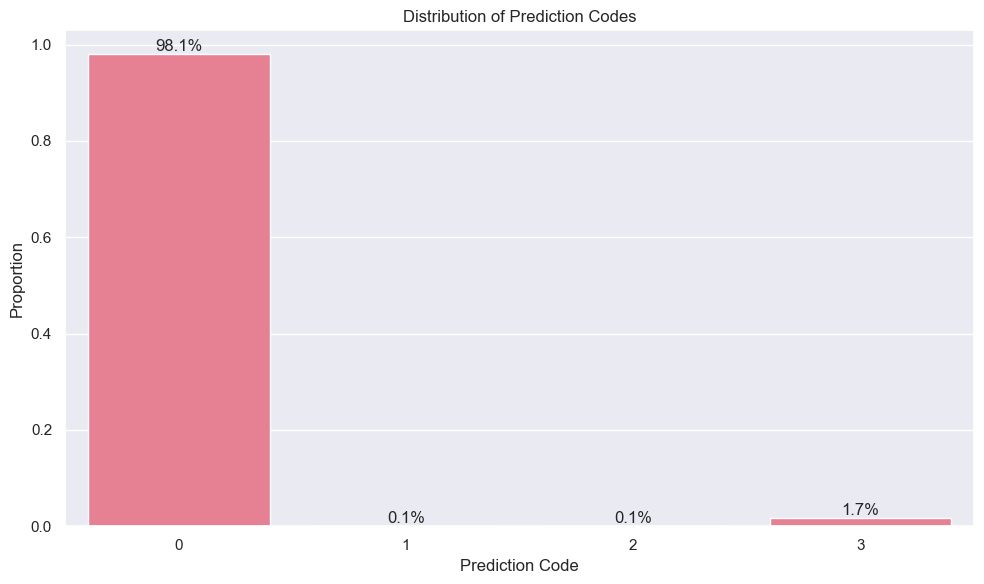


Prediction Code Distribution:
Code 0: 98.1%
Code 1: 0.1%
Code 2: 0.1%
Code 3: 1.7%


In [45]:
# Cell 15: Overall Prediction Distribution
plt.figure(figsize=(10, 6))
prediction_dist = df['prediction'].value_counts(normalize=True).sort_index()
sns.barplot(x=prediction_dist.index, y=prediction_dist.values)
plt.title('Distribution of Prediction Codes')
plt.xlabel('Prediction Code')
plt.ylabel('Proportion')
plt.grid(True, axis='y')

# Add percentage labels on top of bars
for i, v in enumerate(prediction_dist):
    plt.text(i, v, f'{v:.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nPrediction Code Distribution:")
for code, prop in prediction_dist.items():
    print(f"Code {code}: {prop:.1%}")

In [46]:
# Cell 16: Detailed Analysis of Codes 2 and 3
# Calculate proportion of codes 2 and 3 per ID_TRAMO
code_proportions = df.groupby('ID_TRAMO')['prediction'].apply(
    lambda x: pd.Series({
        'prop_code_2': (x == 2).mean(),
        'prop_code_3': (x == 3).mean(),
        'total_records': len(x)
    })
).unstack()

print("ID_TRAMOs with highest proportion of Code 2:")
print(code_proportions.nlargest(5, 'prop_code_2')[['prop_code_2', 'total_records']])
print("\nID_TRAMOs with highest proportion of Code 3:")
print(code_proportions.nlargest(5, 'prop_code_3')[['prop_code_3', 'total_records']])

# Calculate spread of these codes
print("\nSpread Analysis:")
print(f"Number of ID_TRAMOs with any Code 2: {(code_proportions['prop_code_2'] > 0).sum()}")
print(f"Number of ID_TRAMOs with any Code 3: {(code_proportions['prop_code_3'] > 0).sum()}")

ID_TRAMOs with highest proportion of Code 2:
          prop_code_2  total_records
ID_TRAMO                            
3995         0.916667          288.0
7872         0.916667          288.0
8017         0.916667          288.0
1450         0.604167          288.0
5001         0.604167          288.0

ID_TRAMOs with highest proportion of Code 3:
          prop_code_3  total_records
ID_TRAMO                            
14                1.0          288.0
67                1.0          288.0
756               1.0          288.0
757               1.0          288.0
758               1.0          288.0

Spread Analysis:
Number of ID_TRAMOs with any Code 2: 8
Number of ID_TRAMOs with any Code 3: 117


<Figure size 1200x600 with 0 Axes>

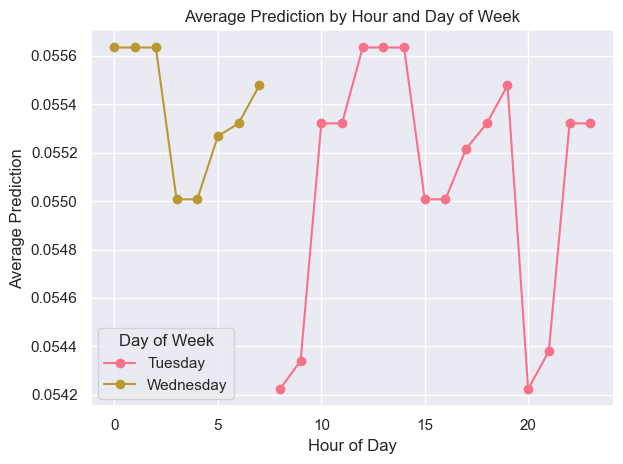

In [47]:
# Cell 17: Temporal Pattern Analysis
# Add day of week
df['day_of_week'] = df['timestamp'].dt.day_name()

# Calculate average prediction by hour and day
avg_by_hour_day = df.pivot_table(
    index='hour',
    columns='day_of_week',
    values='prediction',
    aggfunc='mean'
)

plt.figure(figsize=(12, 6))
avg_by_hour_day.plot(marker='o')
plt.title('Average Prediction by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Average Prediction')
plt.grid(True)
plt.legend(title='Day of Week')
plt.tight_layout()
plt.show()

ID_TRAMOs with highest average predictions:
          mean  std  count
ID_TRAMO                  
14         3.0  0.0    288
67         3.0  0.0    288
756        3.0  0.0    288
757        3.0  0.0    288
758        3.0  0.0    288

ID_TRAMOs with lowest average predictions:
          mean  std  count
ID_TRAMO                  
7          0.0  0.0    288
13         0.0  0.0    288
19         0.0  0.0    288
55         0.0  0.0    288
58         0.0  0.0    288


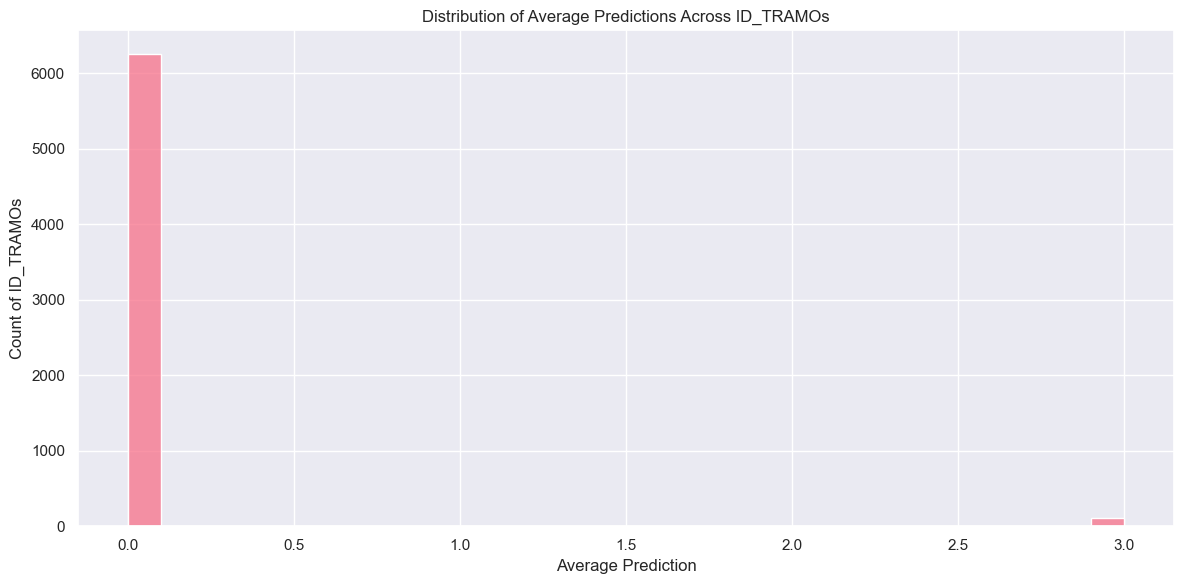

In [48]:
# Cell 18: Spatial Analysis
# Calculate average predictions per ID_TRAMO
tramo_stats = df.groupby('ID_TRAMO')['prediction'].agg([
    'mean',
    'std',
    'count'
]).round(3)

print("ID_TRAMOs with highest average predictions:")
print(tramo_stats.nlargest(5, 'mean'))
print("\nID_TRAMOs with lowest average predictions:")
print(tramo_stats.nsmallest(5, 'mean'))

# Plot distribution of average predictions
plt.figure(figsize=(12, 6))
sns.histplot(tramo_stats['mean'], bins=30)
plt.title('Distribution of Average Predictions Across ID_TRAMOs')
plt.xlabel('Average Prediction')
plt.ylabel('Count of ID_TRAMOs')
plt.grid(True)
plt.tight_layout()
plt.show()

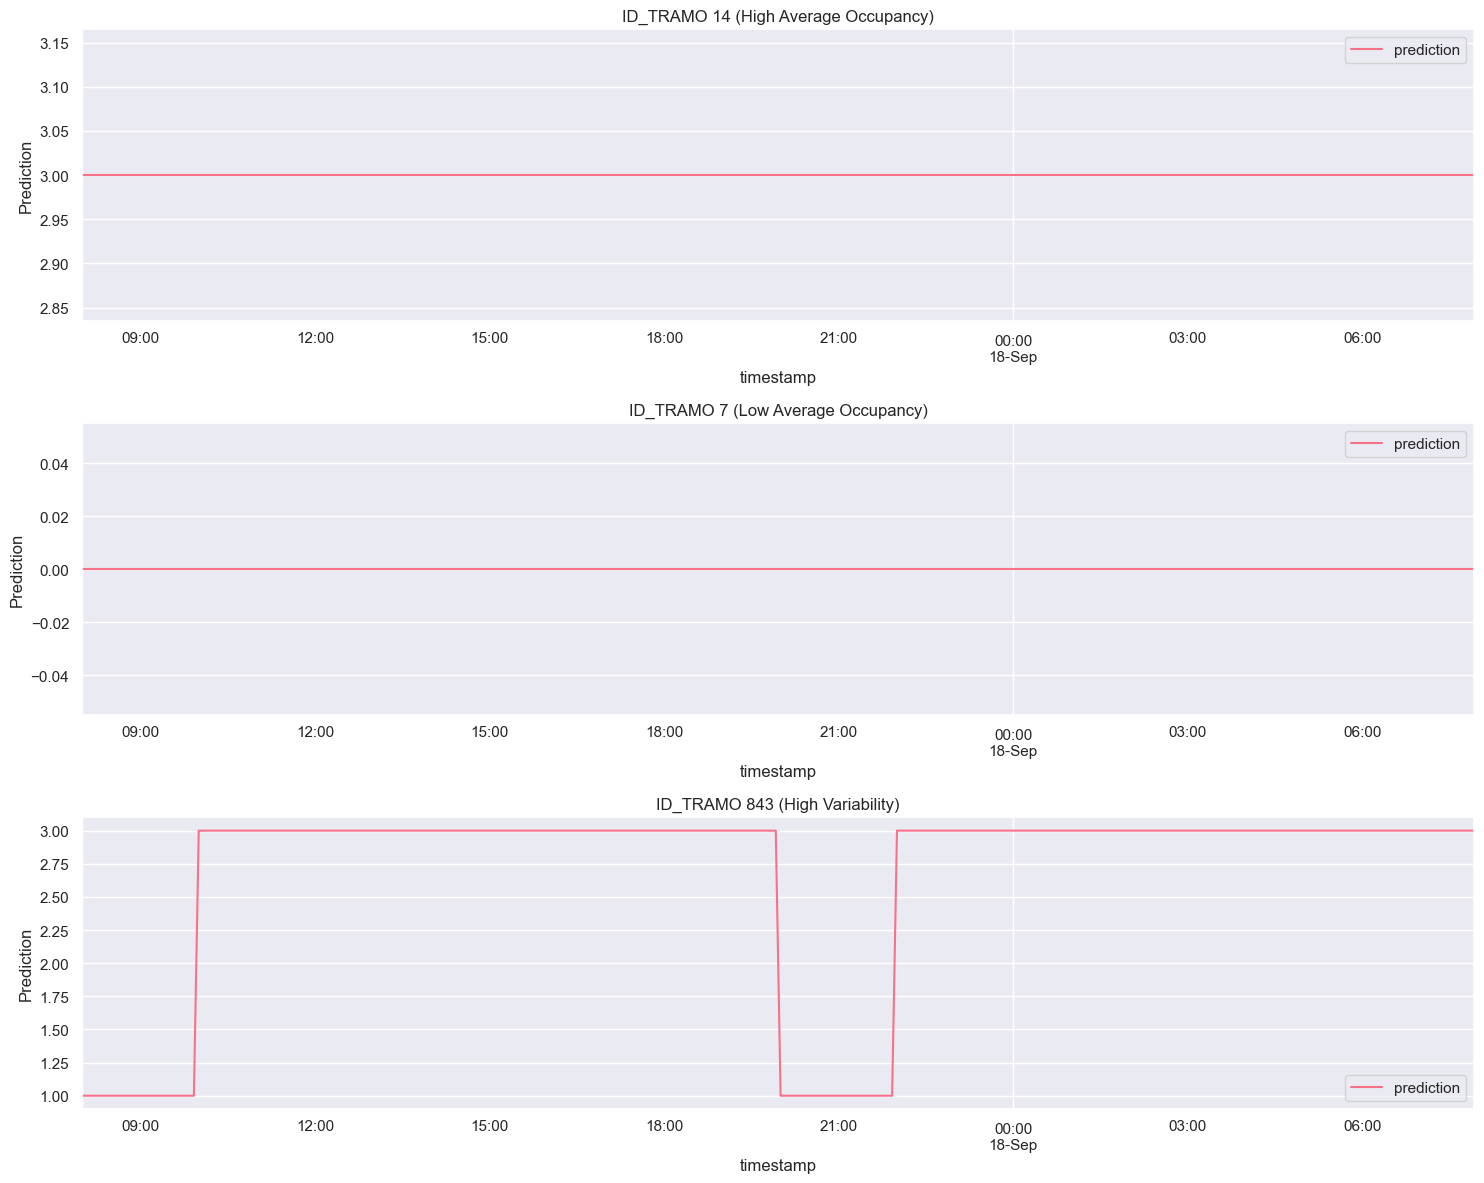

In [49]:
# Cell 19: Individual Section Analysis
# Select representative ID_TRAMOs
high_avg_tramo = tramo_stats.nlargest(1, 'mean').index[0]
low_avg_tramo = tramo_stats.nsmallest(1, 'mean').index[0]
high_var_tramo = tramo_stats.nlargest(1, 'std').index[0]

# Plot predictions over time for these sections
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

for ax, tramo, title in zip(
    axes,
    [high_avg_tramo, low_avg_tramo, high_var_tramo],
    ['High Average Occupancy', 'Low Average Occupancy', 'High Variability']
):
    df[df['ID_TRAMO'] == tramo].plot(
        x='timestamp',
        y='prediction',
        ax=ax,
        title=f'ID_TRAMO {tramo} ({title})'
    )
    ax.grid(True)
    ax.set_ylabel('Prediction')

plt.tight_layout()
plt.show()

In [50]:
# Cell 20: Update summary with data scope and completeness information
additional_summary = f"""
## Data Quality and Scope Analysis

### Temporal Coverage
- Date Range: {df['timestamp'].min().strftime('%Y-%m-%d')} to {df['timestamp'].max().strftime('%Y-%m-%d')}
- Time Granularity: {time_diffs.median()}
- Data Completeness: {(records_per_tramo >= 24*12*2).mean():.1%} of ID_TRAMOs have complete data

### Prediction Distribution
- Code 0: {prediction_dist.get(0, 0):.1%}
- Code 1: {prediction_dist.get(1, 0):.1%}
- Code 2: {prediction_dist.get(2, 0):.1%}
- Code 3: {prediction_dist.get(3, 0):.1%}

### Spatial Coverage
- Total unique ID_TRAMOs: {len(records_per_tramo)}
- ID_TRAMOs with Code 2: {(code_proportions['prop_code_2'] > 0).sum()}
- ID_TRAMOs with Code 3: {(code_proportions['prop_code_3'] > 0).sum()}

### Key Findings from Additional Analysis
1. Temporal Patterns:
   - {avg_by_hour_day.idxmax().max()} shows highest average predictions
   - Daily pattern shows {avg_by_hour_day.max().max() - avg_by_hour_day.min().min():.2f} range in predictions

2. Spatial Patterns:
   - Average prediction across ID_TRAMOs: {tramo_stats['mean'].mean():.2f}
   - Standard deviation across ID_TRAMOs: {tramo_stats['mean'].std():.2f}

### Data Limitations
- Limited to {(df['timestamp'].max() - df['timestamp'].min()).days + 1} days of data
- Weekend patterns not observable in this dataset
- Geographic location information not available
- No external metadata (capacity, tariffs, zone types)
"""

# Append to summary file
with open('notebooks/analysis_code_2_3_patterns_summary.md', 'a') as f:
    f.write('\n\n' + additional_summary)

print("Summary updated with comprehensive data scope and quality analysis.")

Summary updated with comprehensive data scope and quality analysis.
